## Libraries and Global Functions

In [1]:
import sys
import contextlib
import numpy as np
from scipy.integrate import quad
from scipy.optimize import root
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import seaborn as sns # type: ignore
from IPython.display import display, Latex

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def gen_lambda(M, alpha):
    return torch.diag(torch.tensor([ float(k**(-alpha)) for k in range(1, M+1)], device = device))

## The Silverstein Equation

Here we briefly review the prescription for extracting the spectral density via the Silvertstein equation. We will take the following form of the Silvertstein equation as a given
\begin{align*}
m_F(z) = \int \frac{1}{t \Delta+z} dH(t)
\end{align*}
where
\begin{align*}
\Delta = -1+q-qzm_F(z)
\end{align*}
and $dH(t)$ is the PDF for the eigenvalues in the covariance matrix from which features are sampled.  For the case of a white Wishart, $dH(t) = \delta(t-1) dt$ and we recover
\begin{align*}
\frac{1}{m_F} = -1+q-qzm_F
\end{align*}
from which we get the usual Marcenko-Pastur law. Below we include a brief digression recovering Marcenko-Pastur numerically. Recall that the spectral density is obtained via
\begin{align*}
\rho(z) = \lim_{\epsilon \to 0^+} \frac{1}{\pi}\text{Im}[m_F(z+i\epsilon)]
\end{align*}
So in order to acquire the spectral density, we find the complex solution to the Silverstein equation for a given $z$ slightly above the real axis, and then take the imaginary part.  

## Marcenko-Pastur Review

Empirical data

In [4]:
alpha = 0
M = 1000
q = 1/3


dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))


PSI = dist.sample((int(M/q), ))
cov = PSI.T @ PSI /PSI.shape[0]
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]

numerical root finding

In [110]:
eps = 1e-8

def diff(z, mf):
  int_re = lambda t: np.real(alpha*t**(-1+1/alpha)/( t*(-1 + q - q*z*mf) + z ))
  int_im = lambda t: np.imag(alpha*t**(-1+1/alpha)/( t*(-1 +q - q*z*mf) + z ))
  re = np.real(1/( (-1 + q - q*z*mf) + z ))
  im = np.imag(1/( (-1 + q - q*z*mf) + z ))

  return [np.real(mf)-re, np.imag(mf)-im]


def get_rho(z):

  def complex_zero(mflist):
    return diff(z, mflist[0]+1j*mflist[1])


  with contextlib.redirect_stdout(None):
    result = root(complex_zero, [0.5, 0.5], method='hybr')


  if result.success:
    return result.x[1]/np.pi
  else:
    print("Root finding failed:", result.message)

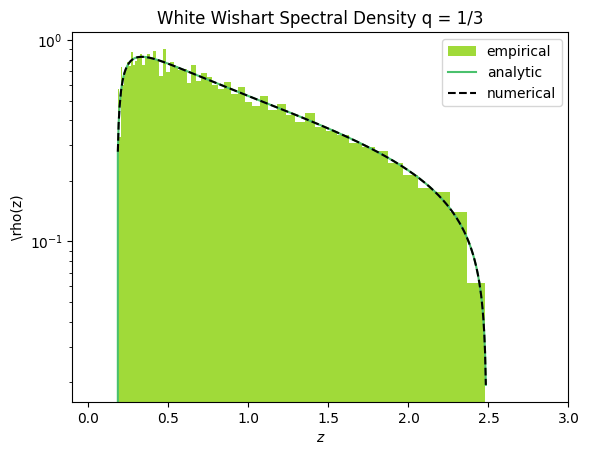

In [111]:
#analytic solution Marcenko-Pastur

lm, lp =  (1-np.sqrt(q))**2, (1+np.sqrt(q))**2
mp_z = np.arange(lm, lp, 5e-3)
rho_an = [np.sqrt((lp-z)*(z-lm))/(2*np.pi)/q/z for z in mp_z ]

#numerical solution to Marcenko-Pastur
rho_num = [get_rho(z+1j*eps) for z in mp_z]

sns.set_palette("viridis_r")

plt.hist([eig.cpu() for eig in eigs], bins=np.logspace(-1,1, 100), label="empirical", density = True)
plt.plot(mp_z, rho_an, label = "analytic")
plt.plot([mp_z[i] for i in range(len(mp_z)) if rho_num[i] > 0], [rho for rho in rho_num if rho > 0], "k--", label = "numerical")
#plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$z$")
plt.ylabel(r"\rho(z)")
plt.xlim(-.1, 3)
plt.title(r"White Wishart Spectral Density q = 1/3")
plt.legend()
plt.savefig("figures/wishart_white_q1_3.png")
plt.show()

## More on dH(t)

For a power law, discretely the number of eigenvalues $t_k = k^{-\alpha}$ is counted by
\begin{align*}
N = \sum\limits_k t_k^{-1/\alpha}
\end{align*}
which is like the CDF. The associated PDF  in t is then
\begin{align*}
dH(t) \propto t^{-1-1/\alpha}dt
\end{align*}
but we must handle the subtelty of the non-integrable singularity at $t = 0$. This can be handled with a cutoff:
\begin{align*}
1 = c \int\limits_{\Lambda}^1 t^{-1-1/\alpha} dt
\end{align*}
where we introduce the normalization constant for the distribution. For practically purposes, working at finite $M$, we will use a cutoff $\Lambda$ in this way, and employ suitable changes of variables to help the integration and root-finding with convergence.  In this case we have
\begin{align*}
c = \frac{1}{\alpha}\frac{\Lambda^{1/\alpha}}{1-\Lambda^{1/\alpha}}
\end{align*}
so that
\begin{align*}
dH(t) = \frac{1}{\alpha}\frac{\Lambda^{1/\alpha}}{1-\Lambda^{1/\alpha}}t^{-1-1/\alpha}
\end{align*}
with this in hand, we can solve the Silverstein equation in the power-law setting.

## Power Law Case

In [2]:
#hyperparams for power-law spectral density
eps = 1e-9
alpha = 1.5
M = 1000
Lc = M**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

#hyper params for student-teacher model MOVE
sigmaw = 1
sigmaw0 = 0
sigmae = 5e-3
tau = 1e3

def diff(q, z, mf):
    delta = (-1 + q - q*z*mf)

    int_re = lambda t: np.real(c*np.exp(t+t/alpha)/( mf*(Lc*delta + z*np.exp(t)) ))
    int_im = lambda t: np.imag(c*np.exp(t+t/alpha)/( mf*(Lc*delta + z*np.exp(t) ) ))
    diff_re, _ = quad(int_re, np.log(Lc), 0)
    diff_im, _ = quad(int_im, np.log(Lc), 0)

    return [1-diff_re, diff_im]

def get_rho(q, z, mf0 = None):

    def complex_zero(mflist):
      return diff(q, z, mflist[0]+1j*mflist[1])


    with contextlib.redirect_stdout(None):
      result = root(complex_zero, [1/np.real(z), 1/np.real(z)] if mf0 is None else mf0, method='hybr')


    if result.success:
      return result.x[1]/np.pi, [result.x[0], result.x[1]]
    else:
      return None, None
      print("Root finding failed:", result.message)

def rho_list(q, zlist):


  out_dict = {}
  out_dict[zlist[0]], mf0 = get_rho(q, zlist[0]+1j*eps)

  for z in zlist[1:]:
    out_dict[z], mf0 = get_rho(q, z+1j*eps, mf0)
  return out_dict

def end_pts(spec_dict):
  deriv_dict = {}
  sorted_keys = sorted(list(spec_dict.keys()))
  for i in range(len(sorted_keys)-1):
    z0 = sorted_keys[i]
    if spec_dict[z0] is None:
      continue
    z1 = [z for z in sorted_keys[i+1:] if spec_dict[z] is not None][0]
    deriv_dict[z0] = (np.log(abs(spec_dict[z1])/abs(spec_dict[z0])))

  #print(deriv_dict)
  z_L = max([z for z in sorted_keys[:len(sorted_keys)//2] if spec_dict[z] is not None], key = lambda z: deriv_dict[z])
  z_R = min([z for z in sorted_keys[len(sorted_keys)//2:-1] if spec_dict[z] is not None], key = lambda z: deriv_dict[z])

  return z_L, z_R

empirical data

In [113]:
M = 1000
q = 2


dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))


PSI = dist.sample((int(M/q), ))
cov = PSI.T @ PSI /PSI.shape[0]
eigs = sorted(torch.linalg.eigvalsh(cov))[::-1]

theory data

In [115]:
%%capture
zs = np.logspace(-7, 0.5, 500)[::-1]
q = 2

spec_dict = rho_list(q, zs)

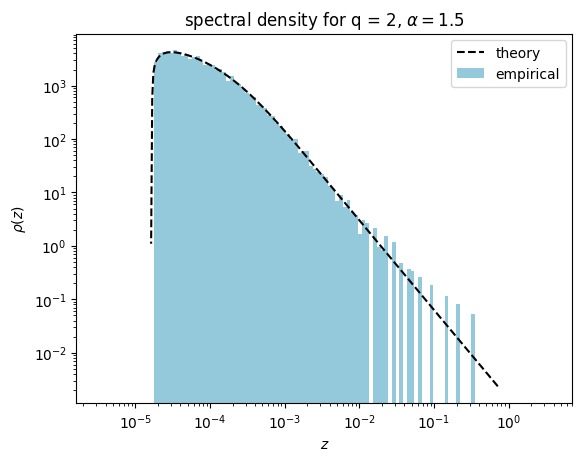

In [116]:
sns.set_palette("ocean_r")

zL, zR = end_pts(spec_dict)

plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL], [q*abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL], "k--", label="theory")
plt.hist([eig.cpu() for eig in eigs], bins=np.logspace(-5,0, 100), label="empirical", density = True)
plt.xlim(zL/10, zR*10)
plt.title(r"spectral density for q = 2, $\alpha = 1.5$")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.savefig("figures/wishart_power_q2.png")
plt.legend()

Checking the density is normalized correctly

In [117]:
(1-1/q)+np.trapz([z*abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL], [np.log(z) for z in spec_dict.keys() if zR >= z >= zL][::-1]) 

0.9997616443449682

### Extreme q values

#### q = 1/10

In [93]:
%%capture
zs = np.logspace(-7, 0, 500)[::-1]
q = 1/10

spec_dict = rho_list(q, zs)

In [94]:
np.trapz([z*abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL], [np.log(z) for z in spec_dict.keys() if zR >= z >= zL][::-1]) 

0.9926547618152407

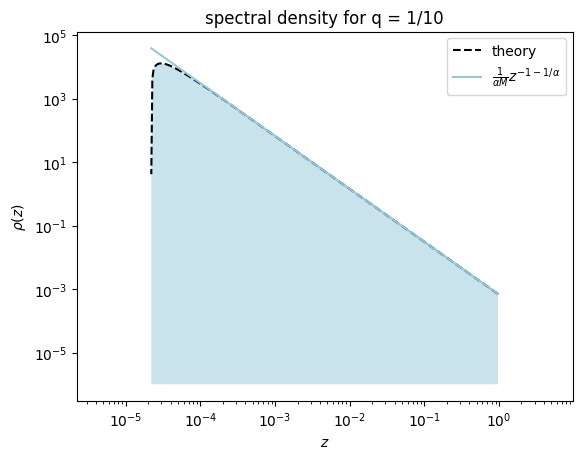

In [95]:
sns.set_palette("ocean_r")

zL, zR = end_pts(spec_dict)

plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL], [abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL], "k--", label= "theory")
plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL], [1/alpha*M**(-1)*z**-(1+1/alpha) for z in spec_dict.keys() if zR >= z >= zL] , label=r"$\frac{1}{\alpha M} z^{-1-1/\alpha}$")
plt.fill_between([z for z in spec_dict.keys() if zR >= z >= zL],[1e-6 for z in spec_dict.keys() if zR >= z >= zL] ,[abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL], alpha=0.5)
plt.xlim(zL/10, zR*10)
plt.title(r"spectral density for q = 1/10")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.savefig("figures/wishart_power_q1_10.png")
plt.legend()

In [96]:
zL, zR

(2.2013311074930325e-05, 0.9682153059967076)

#### q = 1/50

In [116]:
%%capture
zs = np.logspace(-7, 0.5, 500)[::-1]
q = 1/50

spec_dict = rho_list(q, zs)

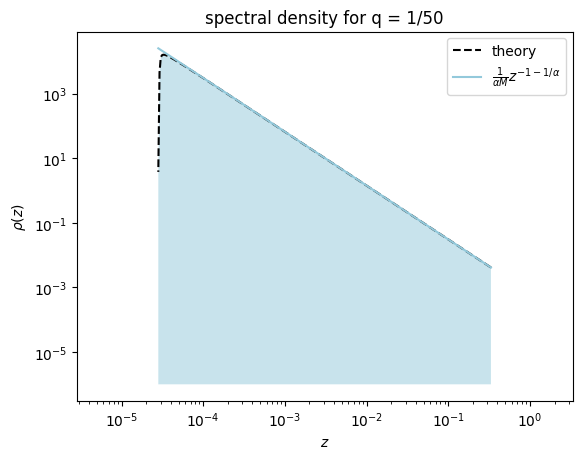

In [117]:
sns.set_palette("ocean_r")

zL, zR = end_pts(spec_dict)


plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], "k--", label= "theory")
plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [1/alpha*M**-1*z**-(1+1/alpha) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None] , label=r"$\frac{1}{\alpha M} z^{-1-1/\alpha}$")
plt.fill_between([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None],[1e-6 for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None] ,[abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], alpha=0.5)
plt.xlim(zL/10, zR*10)
plt.title(r"spectral density for q = 1/50")
plt.xlabel(r"$z$")
plt.ylabel(r"$\rho(z)$")
plt.savefig("figures/wishart_power_q1_50.png")
plt.legend()

We see that for extreme values of $q$ we converge toward a quadrilateral bound by $c*z^{-1-1/\alpha}$ for some constant $c$, and between $z_L$ and $z_R$. Knowledge of two of these variables, plus the normalization condition would totally determine the spectral density.

In [108]:
zL, zR 

(2.8255448444335437e-05, 0.07805213185467409)

The limiting form of the spectral density is the population density.

For large $M$ this is simply
\begin{align*}
\boxed{\rho(z) = \begin{cases}
0  & z < M^{-\alpha}\\
\frac{1}{\alpha M} z^{-1-1/\alpha} & M^{-\alpha} < z < 1\\
0 & z > 1\\
\end{cases}}
\end{align*}

### Near Equiparameterized

In [98]:
eigs = {}
alpha = 1.7
dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(M, device = device), gen_lambda(M, alpha))
for q in [1/3, .99, 3]:
  T = int(M/q)
  PSI = dist.sample((T, ))
  cov = PSI.T @ PSI /T
  eigs[q] = sorted(torch.linalg.eigvalsh(cov))[::-1]

In [99]:
%%capture
zs = np.logspace(-12, 0.5, 600)[::-1]
q = .99
alpha = 1.7
Lc = M**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

spec_dict = rho_list(q, zs)

(1-1/q)+np.trapz([z*abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [np.log(z) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None][::-1], dx = .001)

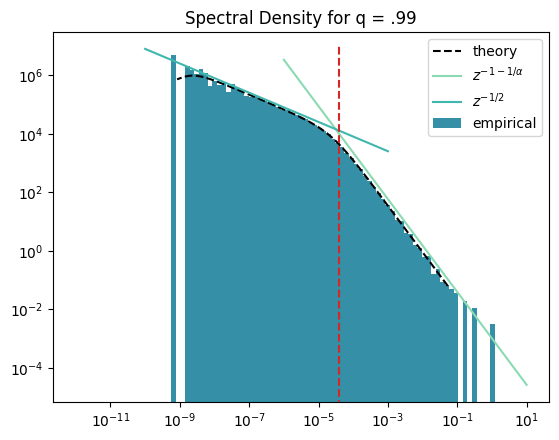

In [103]:
sns.set_palette("mako_r")

zL, zR = end_pts(spec_dict)
plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], "k--", label= "theory")
plt.loglog([z for z in np.logspace(-6, 1, 20)], [1e-3*z**-(1+1/alpha) for z in np.logspace(-6, 1, 20)], label=r"$z^{-1-1/\alpha}$")
plt.loglog([z for z in np.logspace(-10, -3, 20)], [8e1*z**-(.5) for z in np.logspace(-10, -3, 20)], label=r"$z^{-1/2}$")
plt.vlines(4e-5, 1e-9, 1e7, colors="tab:red", linestyles="dashed")
plt.hist([eig.cpu() for eig in eigs[.99]], bins =np.logspace(-12, 1, 100), density=True, label="empirical")
plt.xscale("log")
plt.yscale("log")
plt.title("Spectral Density for q = .99")
plt.legend()
plt.savefig("figures/wishart_q99.png")
plt.show()

As with Marcenko-Pastur, there is a transition from the population scaling of the larger eigenvalues to the square-root scaling of the smaller eigenvalues. About have of the eigenvalues are on each side.

In [107]:
%%capture

hist, bin_edges = np.histogram([eig.cpu() for eig in eigs[.99]], bins=np.logspace(-10,0, 100), density=True)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

zs = bin_midpoints
spec_dict = rho_list(q, zs)
zL, zR = end_pts(spec_dict)

rho_excess = [(hist[i]-abs(spec_dict[z]))/hist[i] for i, z in enumerate(bin_midpoints) if zR >= z >= zL and spec_dict[z] is not None]


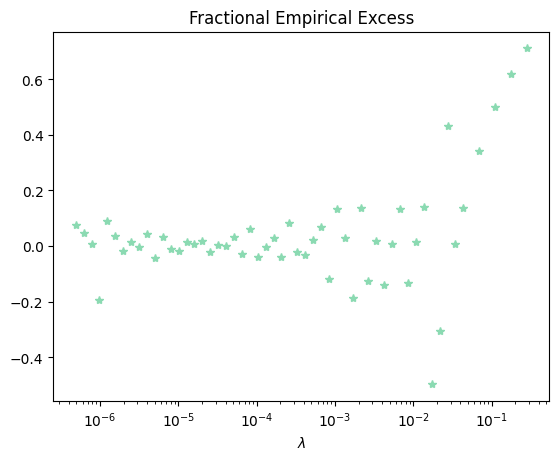

In [108]:
plt.plot([z for z in bin_midpoints if zR >= z >= zL and spec_dict[z] is not None], rho_excess, "*")
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.title(r"Fractional Empirical Excess")
plt.savefig("figures/wishart_empirical_excess.png")

We see a an expected roughly symmetric dispersion around 0.0, indicating a good fit.

## Natural Datasets

### CIFAR-10

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
Xtr = torch.cat([data for data, labels in trainloader]).view(50000, 32*32*3)
Xtr = Xtr.to(dtype=torch.float64, device = device)
Xcent = Xtr-Xtr.mean(axis = 0)
C = Xcent.T @ Xcent/Xcent.shape[0]
eigs_cifar = sorted(torch.linalg.eigvalsh(C))[::-1]

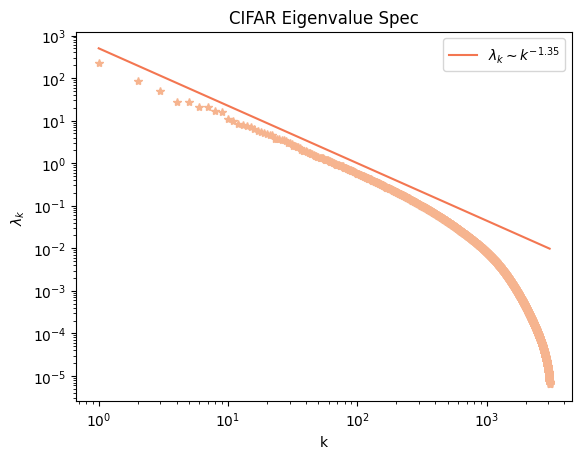

In [92]:
sns.set_palette("rocket_r")



plt.loglog(range(1, len(eigs_cifar)+1), eigs_cifar, "*")
plt.loglog(range(1, len(eigs_cifar)+1), [5e2*l**-1.35 for l in range(1, len(eigs_cifar)+1)], label=r"$\lambda_k \sim k^{-1.35}$")
plt.xlabel(r"k")
plt.ylabel(r"$\lambda_k$")
plt.title("CIFAR Eigenvalue Spec")
plt.legend()
plt.savefig("figures/cifar_eigenvalues.png")
plt.show()

In [93]:
%%capture
zs = np.logspace(-6, -.2, 600)[::-1]
q = 32*32*3/50000
alpha = 1.35
M = 32*32*3
Lc = 5e-1*M**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

spec_dict = rho_list(q, zs)
zL, zR = end_pts(spec_dict)


In [94]:
np.trapz([z*abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [np.log(z) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None][::-1], dx = .001)

0.9993104177756128

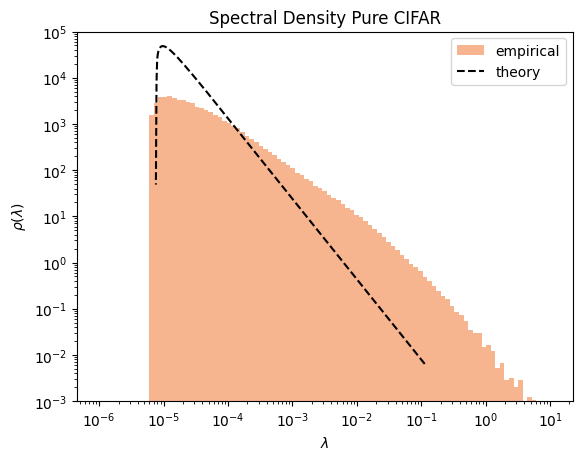

In [95]:
sns.set_palette("rocket_r")


plt.hist([eig.cpu() for eig in eigs_cifar], bins=np.logspace(-6,1, 100), label="empirical", density = True)
plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], "k--", label= "theory")
#plt.plot(mp_l, rho_mp)
plt.ylim(10**-3, 10**5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\rho(\lambda)$")
plt.title(r"Spectral Density Pure CIFAR")
plt.legend()
plt.savefig("figures/cifar_spectral_density.png")
plt.show()

We see the raw CIFAR-10 input would clearly not be well described by a power-law spectral density for any set of parameters, and certainly not for the actual overparameterization ratio and exponent characterizing the data.

#### ReLU Mapping

In [7]:
NReLU = 10000
u = torch.randn((NReLU, 32*32*3), dtype = torch.float64, device = device)
Xtr.to(dtype=torch.float64, device = device)
XReLU = nn.ReLU()(Xtr @ u.T/NReLU)
Xcent = XReLU-XReLU.mean(axis = 0)
CRel = Xcent.T @ Xcent/Xcent.shape[0]
eigs_relu = sorted(torch.linalg.eigvalsh(CRel))[::-1]

Text(0.5, 1.0, '$N_{ReLU} = 10k$ CIFAR Eigenvalue Spec')

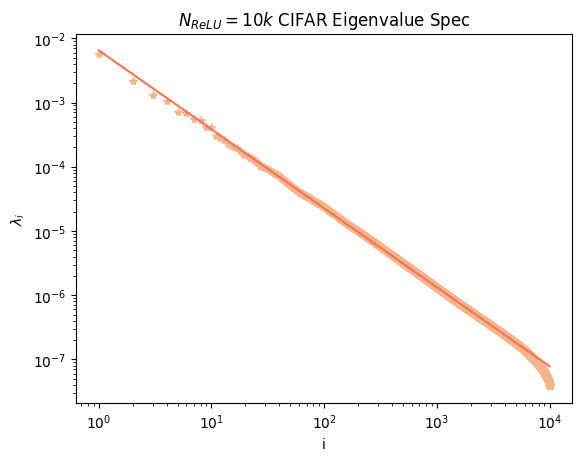

In [ ]:
sns.set_palette("rocket_r")

plt.loglog(range(1, len(eigs_relu)+1), eigs_relu, "*")
plt.loglog(range(1, len(eigs_relu)+1), [6.5e-3*l**-1.23 for l in range(1, len(eigs_relu)+1)])
plt.xlabel(r"i")
plt.ylabel(r"$\lambda_i$")
plt.title(r"$N_{ReLU} = 10k$ CIFAR Eigenvalue Spec")
plt.savefig("figures/relu_cifar_eigenvalues.png")

eigenvalue/power-law

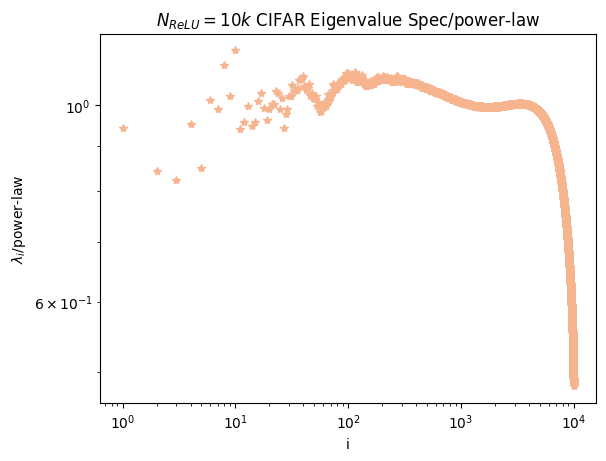

In [15]:
sns.set_palette("rocket_r")

plt.loglog(range(1, len(eigs_relu)+1), [eigs_relu[l-1]/(6e-3*l**-1.22) for l in range(1, len(eigs_relu)+1)], "*")
plt.xlabel(r"i")
plt.ylabel(r"$\lambda_i/$power-law")
plt.title(r"$N_{ReLU} = 10k$ CIFAR Eigenvalue Spec/power-law")
plt.savefig("figures/relu_cifar_eigenvalues-over-power-law.png")

now the spectral density

In [82]:
%%capture
T = 5e4
M = 10000
q = M/T
eps = 1e-9
alpha = 1.23
Lc = 6.45e-3*M**-alpha
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

zs= np.logspace(-7.5, -3, 500)[::-1]
spec_dict = rho_list(q, zs)
zL, zR = end_pts(spec_dict)

In [83]:
np.trapz([z*abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [np.log(z) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None][::-1], dx = .001)

0.9931096393989827

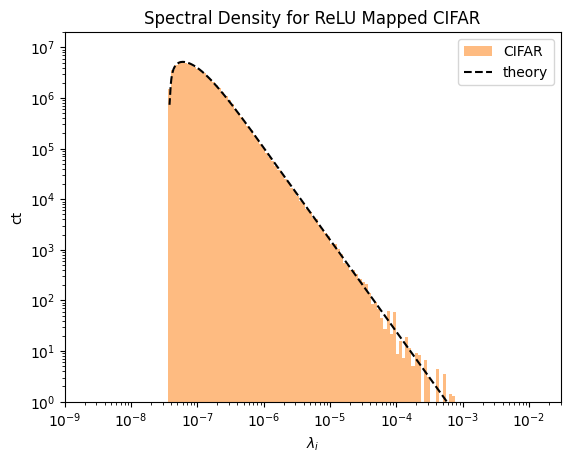

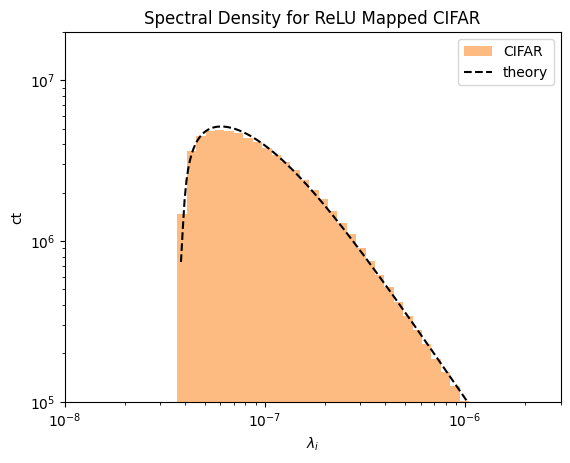

In [90]:
sns.set_palette("magma_r")

plt.hist(eigs_relu, bins=np.logspace(-8,-1, 150), density = True, label="CIFAR")
plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], "k--", label="theory")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\lambda_i$")
plt.ylabel("ct")
plt.title(f"Spectral Density for ReLU Mapped CIFAR")
plt.xlim(1e-9, 3e-2)
plt.ylim(1, 2e7)
plt.legend()
plt.savefig("figures/relu_cifar.png")
plt.show()

sns.set_palette("magma_r")

plt.hist(eigs_relu, bins=np.logspace(-8,-1, 150), density = True, label="CIFAR")
plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], "k--", label="theory")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\lambda_i$")
plt.ylabel("ct")
plt.title(f"Spectral Density for ReLU Mapped CIFAR")
plt.xlim(1e-8, 3e-6)
plt.ylim(1e5, 2e7)
plt.legend()
plt.savefig("figures/relu_cifar_zoom.png")
plt.show()

This fit is a striking improvement, though there remains some structure to the minor deviations.

Let's plot the excess

In [ ]:
%%capture

hist, bin_edges = np.histogram(eigs_relu, bins=np.logspace(-8,-3, 150), density=True)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

zs = bin_midpoints
spec_dict = rho_list(q, zs)
zL, zR = end_pts(spec_dict)

rho_excess = [(hist[i]-abs(spec_dict[z]))/hist[i] for i, z in enumerate(bin_midpoints) if zR >= z >= zL and spec_dict[z] is not None]


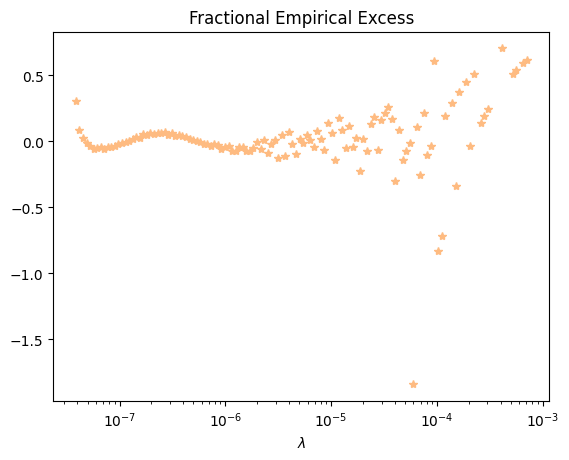

In [81]:
plt.plot([z for z in bin_midpoints if zR >= z >= zL and spec_dict[z] is not None], rho_excess, "*")
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.title(r"Fractional Empirical Excess")
plt.savefig("figures/empirical_excess.png")

The density of smaller eigenvalues still has a structured deviation.

## Wiki-Text

In [4]:
%%capture
zs = np.logspace(-6, 0, 600)[::-1]
q = 1.14
alpha = 1
Lc = 4.5e-4
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

spec_dict = rho_list(q, zs)
zL, zR = end_pts(spec_dict)

In [3]:
eigs = np.load("data/wiki_8k_8k_100k_eigs.npy")

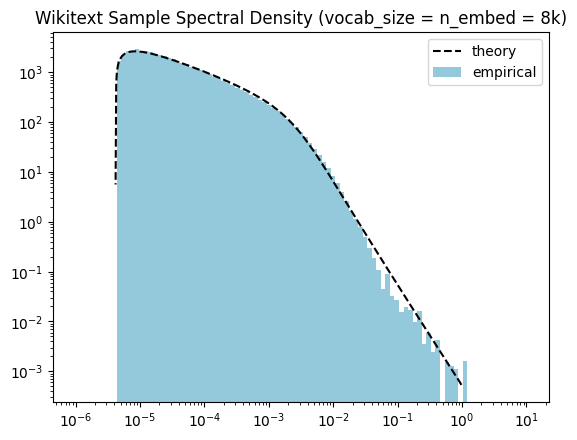

In [5]:
sns.set_palette("ocean_r")

plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [q*abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], "k--", label="theory")
plt.hist(eigs, bins = np.logspace(-6, 1, 100), density = True, label="empirical")
plt.xscale('log')
plt.yscale('log')
plt.title("Wikitext Sample Spectral Density (vocab_size = n_embed = 8k)")
plt.legend()
#plt.savefig("figures/wiki-text-spec.png")
plt.show()

It is striking how well the spectral density is described by something close to equiparameterization even when the dataset size is much greater than the embedding size and vocab size.

Let's look at the excess for this case

In [ ]:
%%capture

hist, bin_edges = np.histogram(eigs, bins = np.logspace(-6, 1, 100), density=True)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

zs = bin_midpoints
spec_dict = rho_list(q, zs)
zL, zR = end_pts(spec_dict)

rho_excess = [(hist[i]-abs(q*spec_dict[z]))/hist[i] for i, z in enumerate(bin_midpoints) if zR >= z >= zL and spec_dict[z] is not None]


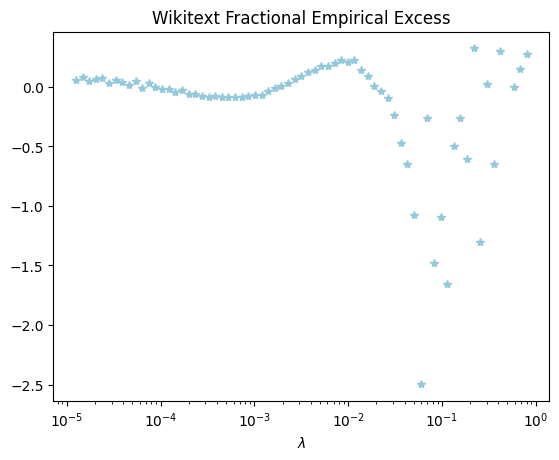

In [7]:
plt.plot([z for z in bin_midpoints if zR >= z >= zL and spec_dict[z] is not None], rho_excess, "*")
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.title(r"Wikitext Fractional Empirical Excess")
plt.savefig("figures/wiki_empirical_excess.png")

Again but with a smaller embedding space.

In [8]:
eigs = np.load("data/wiki_8k_4k_100k_eigs.npy")

In [48]:
%%capture
zs = np.logspace(-6, 0, 600)[::-1]
q = .58
alpha = .98
Lc = 5.7e-4
c = 1/alpha*1/(1-np.power(Lc, 1/alpha))

spec_dict = rho_list(q, zs)
zL, zR = end_pts(spec_dict)

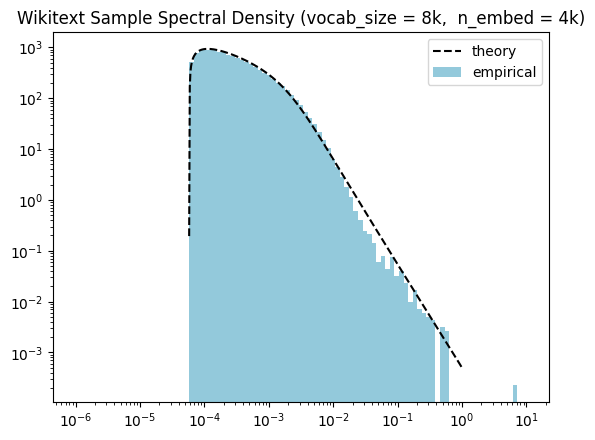

In [49]:
sns.set_palette("ocean_r")

plt.loglog([z for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], [abs(spec_dict[z]) for z in spec_dict.keys() if zR >= z >= zL and spec_dict[z] is not None], "k--", label="theory")
plt.hist(eigs, bins = np.logspace(-6, 1, 100), density = True, label="empirical")
plt.xscale('log')
plt.yscale('log')
plt.title("Wikitext Sample Spectral Density (vocab_size = 8k,  n_embed = 4k)")
plt.legend()
#plt.savefig("figures/wiki-text-spec.png")
plt.show()

In [50]:
%%capture

hist, bin_edges = np.histogram(eigs, bins = np.logspace(-6, 1, 100), density=True)
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

zs = bin_midpoints
spec_dict = rho_list(q, zs)
zL, zR = end_pts(spec_dict)

rho_excess = [(hist[i]-abs(spec_dict[z]))/hist[i] for i, z in enumerate(bin_midpoints) if zR >= z >= zL and spec_dict[z] is not None]

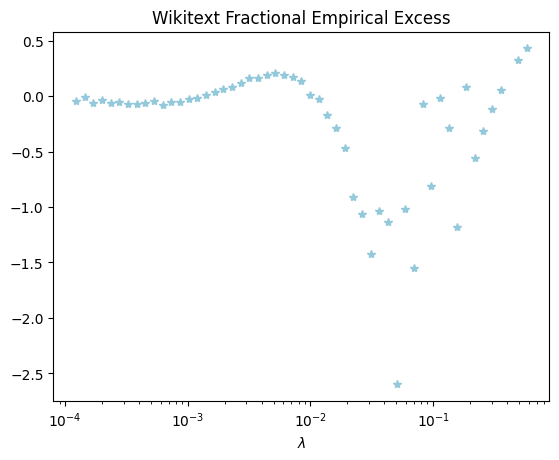

In [51]:
plt.plot([z for z in bin_midpoints if zR >= z >= zL and spec_dict[z] is not None], rho_excess, "*")
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.title(r"Wikitext Fractional Empirical Excess")
plt.savefig("figures/wiki_empirical_excess_4k.png")